<a href="https://colab.research.google.com/github/BaronVonBussin/Stuff/blob/main/XGBvsRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGB Death Match vs Random Forest

Needs work on second section (feature constingency)

In [2]:
!pip install memory-profiler


Testing Contingency Dataset:
Testing contingency Dataset:


Testing Outlier Dataset:
Testing outlier Dataset:


Testing Categorical Dataset:
Testing categorical Dataset:



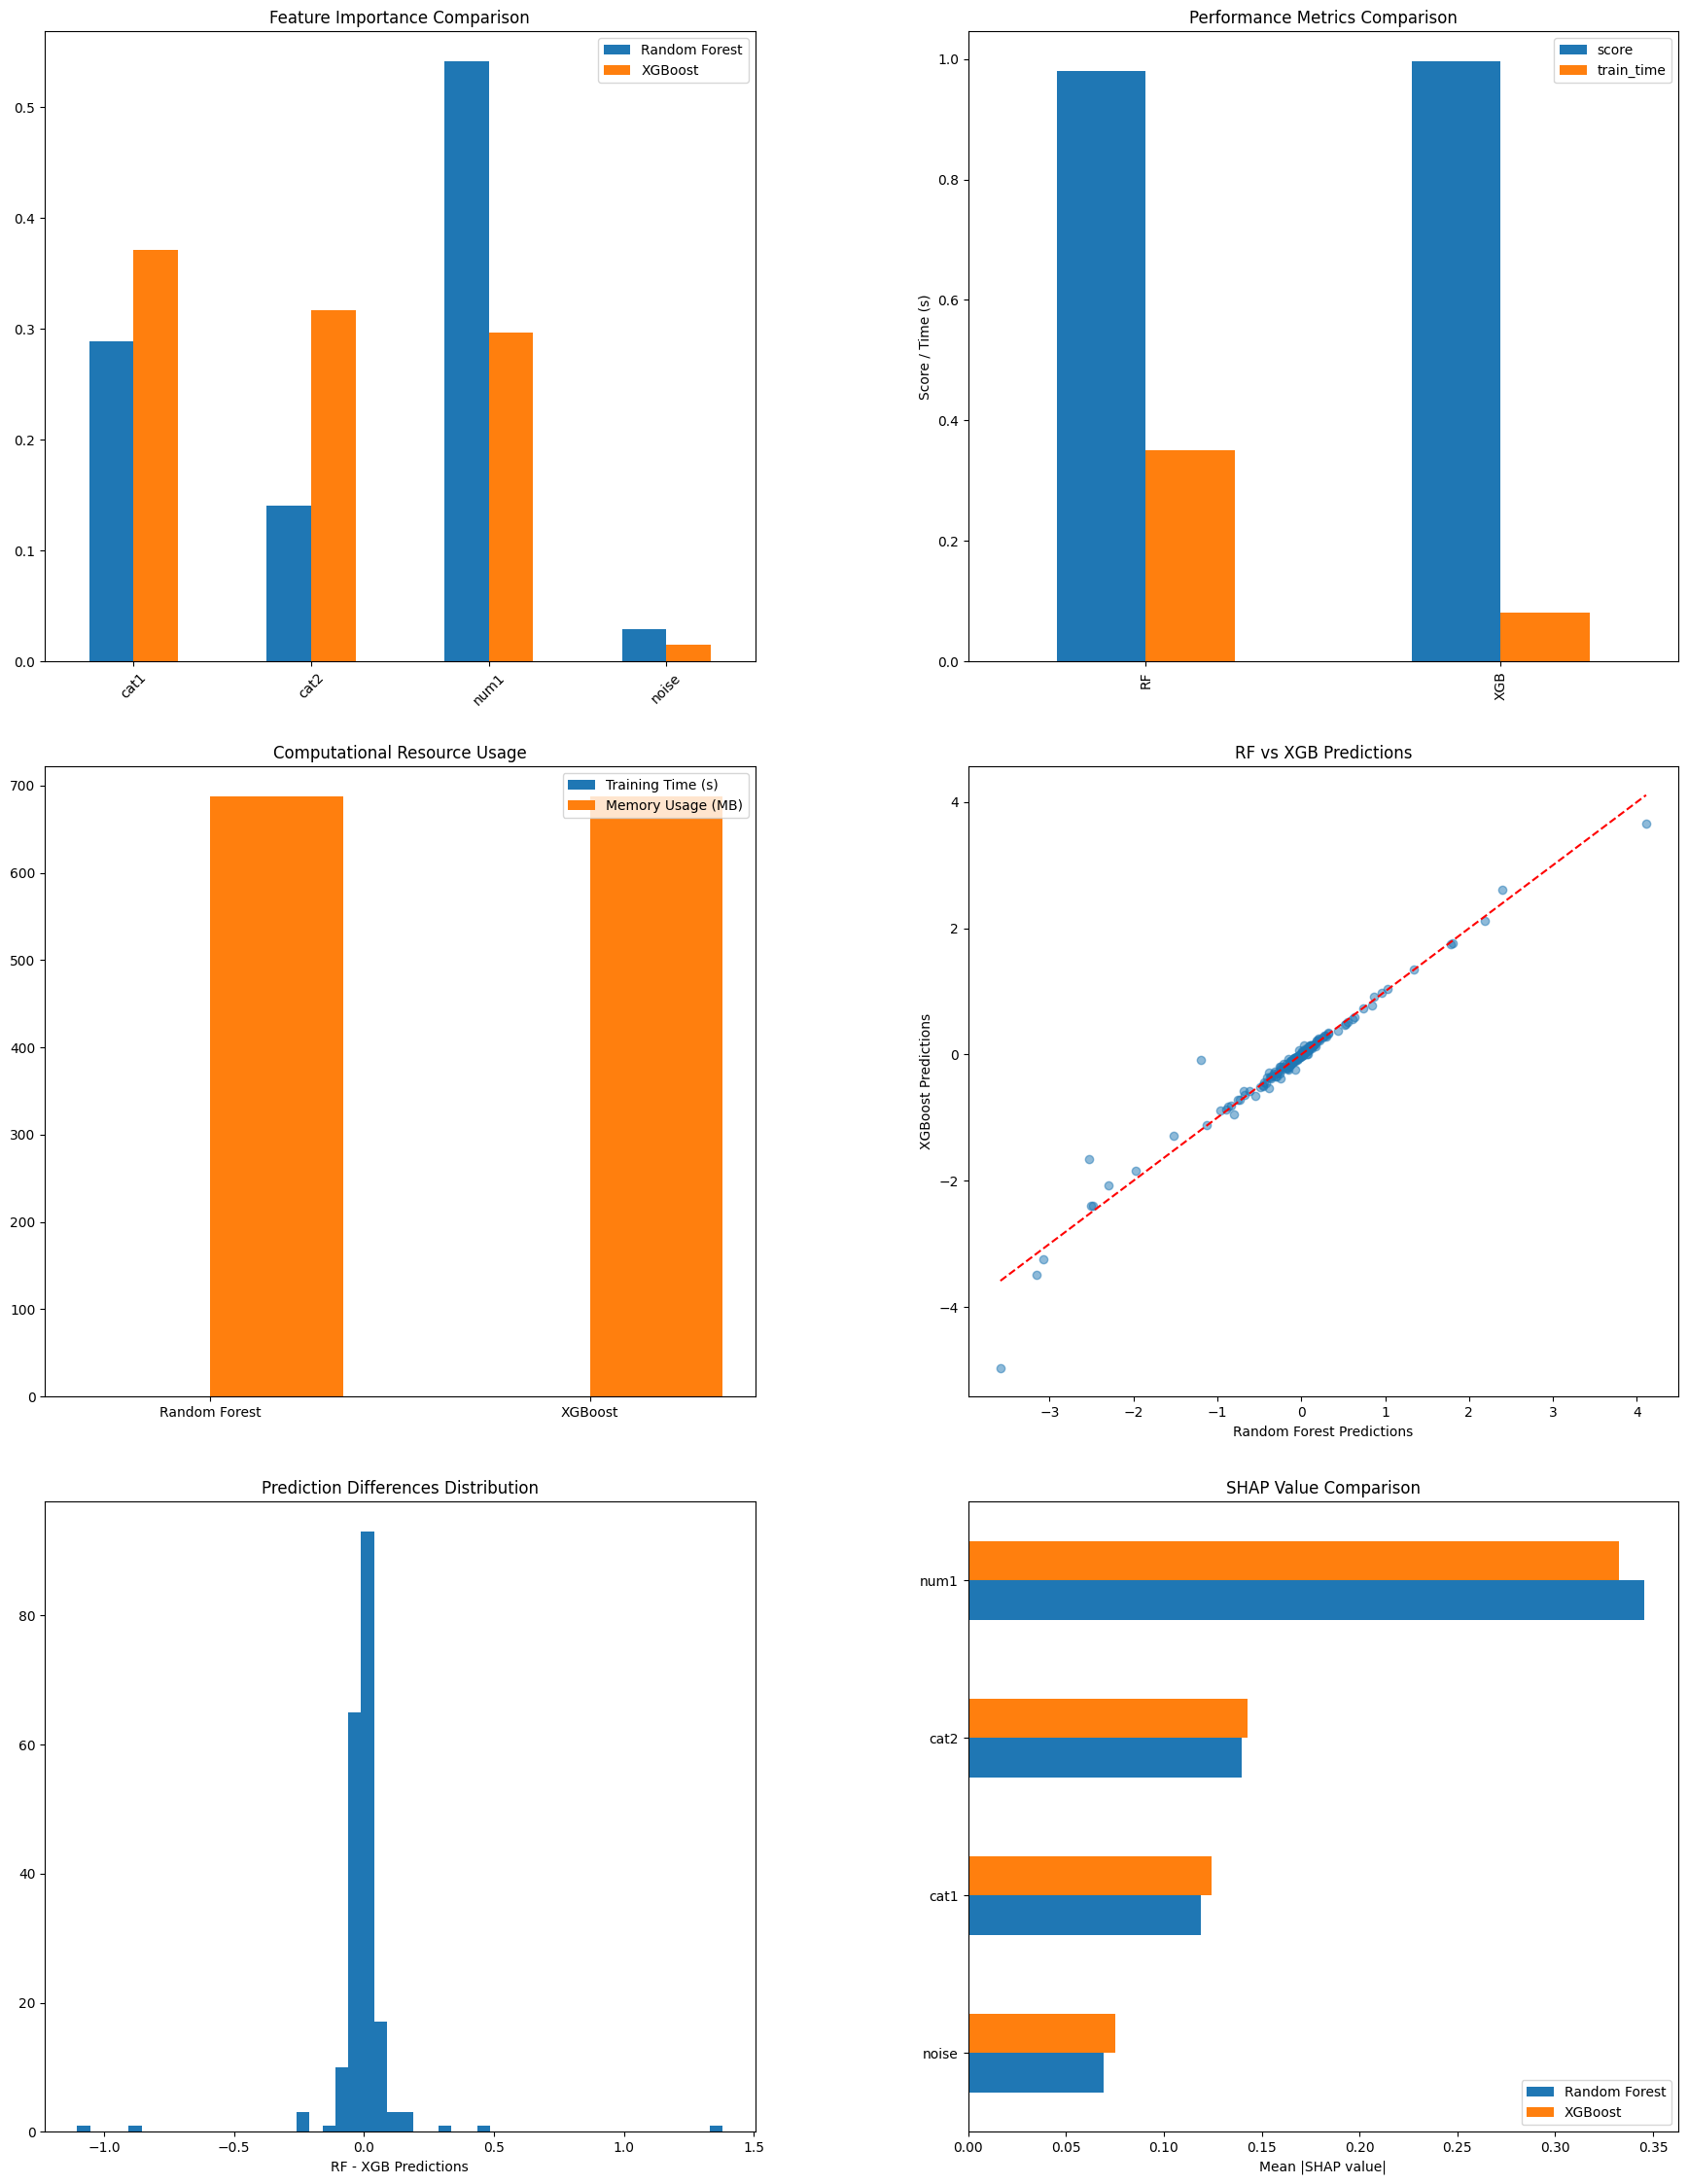

In [48]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl # Import matplotlib and assign it to mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import memory_profiler
from scipy.stats import spearmanr
import shap

class ForestBoostComparator:
    """
    A comprehensive system for comparing XGBoost and Random Forest performance
    across different challenging scenarios.
    """
    def __init__(self):
        self.rf_model = None
        self.xgb_model = None
        self.performance_metrics = {}

    def generate_contingency_dataset(self, n_samples=1000):
        """
        Generate dataset where feature importance is contingent on other features.
        This exposes XGBoost's weakness in handling complex feature interactions.
        """
        np.random.seed(42)

        # Generate base features
        X = pd.DataFrame({
            'x1': np.random.normal(0, 1, n_samples),
            'x2': np.random.normal(0, 1, n_samples),
            'x3': np.random.normal(0, 1, n_samples),
            'noise': np.random.normal(0, 0.1, n_samples)
        })

        # Create contingent relationship
        # y depends on x1 only when x2 and x3 are both positive
        contingency_mask = (X['x2'] > 0) & (X['x3'] > 0)
        y = np.zeros(n_samples)
        y[contingency_mask] = X.loc[contingency_mask, 'x1'] * 2
        y[~contingency_mask] = X.loc[~contingency_mask, 'x2'] * 0.5

        # Add noise
        y += X['noise']

        return X, pd.Series(y, name='target')

    def generate_outlier_dataset(self, n_samples=1000):
        """
        Generate dataset with significant outliers to test robustness.
        """
        X = pd.DataFrame({
            'x1': np.random.normal(0, 1, n_samples),
            'x2': np.random.normal(0, 1, n_samples)
        })

        # Generate target with clean relationship
        y = X['x1'] * 2 + X['x2'] * (-1) + np.random.normal(0, 0.1, n_samples)

        # Add outliers
        outlier_idx = np.random.choice(n_samples, size=int(n_samples * 0.05))
        X.loc[outlier_idx, :] *= 5
        y[outlier_idx] *= 10

        return X, pd.Series(y, name='target')

    #Added generate_categorical_dataset function
    def generate_categorical_dataset(self, n_samples=1000):
        """
        Generate dataset with categorical features to test encoding and handling.
        """
        np.random.seed(42)

        # Generate features
        X = pd.DataFrame({
            'cat1': np.random.choice(['A', 'B', 'C'], size=n_samples),
            'cat2': np.random.choice(['D', 'E', 'F'], size=n_samples),
            'num1': np.random.normal(0, 1, n_samples),
            'noise': np.random.normal(0, 0.1, n_samples)  # Added noise
        })

        # Generate target based on categories and numerical feature with noise
        y = np.zeros(n_samples)
        y[(X['cat1'] == 'A') & (X['cat2'] == 'D')] = X.loc[(X['cat1'] == 'A') & (X['cat2'] == 'D'), 'num1'] * 2
        y[(X['cat1'] == 'B')] = X.loc[(X['cat1'] == 'B'), 'num1'] * 0.5  # Simplified logic
        y += X['noise']  # Incorporate noise in the target

        return X, pd.Series(y, name='target')

    def generate_contingency_dataset(self, n_samples=1000):
        np.random.seed(42)

        # Generate base features with explicit noise control
        X = pd.DataFrame({
            'x1': np.random.normal(0, 1, n_samples),
            'x2': np.random.normal(0, 1, n_samples),
            'x3': np.random.normal(0, 1, n_samples),
            'noise': np.random.normal(0, 0.1, n_samples)
        })

    # Create contingent relationship with proper noise incorporation
        contingency_mask = (X['x2'] > 0) & (X['x3'] > 0)
        y = np.zeros(n_samples)
        y[contingency_mask] = X.loc[contingency_mask, 'x1'] * 2 + X.loc[contingency_mask, 'noise']
        y[~contingency_mask] = X.loc[~contingency_mask, 'x2'] * 0.5 + X.loc[~contingency_mask, 'noise']

        return X, pd.Series(y, name='target')

    def measure_performance(self, X, y, dataset_type):
        """
        Measure and compare performance metrics for both models.
        """
        # Split data
        X_train, self.X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Initialize models
        self.rf_model = RandomForestRegressor(n_estimators=100, oob_score=True)
        self.xgb_model = XGBRegressor(n_estimators=100)

        # Prepare categorical features if needed
        if dataset_type == 'categorical':
            le = LabelEncoder()
            for col in X.select_dtypes(include=['object']):
                X_train[col] = le.fit_transform(X_train[col])
                self.X_test[col] = le.transform(self.X_test[col]) # Change X_test to self.X_test

        # Measure training time and memory usage
        metrics = {}
        for name, model in [('RF', self.rf_model), ('XGB', self.xgb_model)]:
            start_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start_time

            # Predictions and scores
            y_pred = model.predict(self.X_test) # Change X_test to self.X_test
            score = np.corrcoef(y_test, y_pred)[0, 1]

            metrics[name] = {
                'train_time': train_time,
                'score': score,
                'memory_usage': memory_profiler.memory_usage()[0]
            }

            if name == 'RF':
                metrics[name]['oob_score'] = model.oob_score_

        self.performance_metrics[dataset_type] = metrics
        return metrics

    def plot_results(self, dataset_type):

        print(f"Testing {dataset_type} Dataset:\n")
        plt.close('all')

    # Set global plot parameters
        mpl.rcParams['font.size'] = 10
        mpl.rcParams['lines.markersize'] = 8
        mpl.rcParams['lines.linewidth'] = 2
        mpl.rcParams['patch.linewidth'] = 2

    # Create figure and gridspec
        fig = plt.figure(figsize=(20, 24))

        gs = fig.add_gridspec(6, 2,
            height_ratios=[1, 1, 1, 1, 1, 1],
            width_ratios=[1, 1],
            hspace=0.4,  # Vertical space between rows
            wspace=0.3   # Horizontal space between columns
        )

        metrics = self.performance_metrics[dataset_type]

    # Create all subplots using gridspec
        ax_feature = fig.add_subplot(gs[0:2, 0])  # Feature importance takes 2 rows
        ax_perf = fig.add_subplot(gs[0:2, 1])     # Performance metrics takes 2 rows
        ax_train = fig.add_subplot(gs[2:4, 0])    # Training comparison takes 2 rows
        ax_pred1 = fig.add_subplot(gs[2:4, 1])    # First prediction plot takes 2 rows
        ax_pred2 = fig.add_subplot(gs[4:6, 0])    # Second prediction plot takes 2 rows
        ax_shap = fig.add_subplot(gs[4:6, 1])     # SHAP comparison takes 2 rows

    # Plot on each subplot
        with plt.style.context('default'):  # Ensure consistent style
            self._plot_feature_importance(ax_feature)
            self._plot_performance_metrics(metrics, ax_perf)
            self._plot_training_comparison(metrics, ax_train)
            self._plot_prediction_comparison(ax_pred1, ax_pred2)
            self._plot_shap_comparison(ax_shap)

    # Adjust layout
        plt.subplots_adjust(
            top=0.95,
            bottom=0.05,
            left=0.08,
            right=0.92,
            hspace=0.5,
            wspace=0.4
         )

        return plt

        print(f"\nAnalyzing Feature Interactions for {dataset_type} Dataset:\n")
        fig_interactions = plt.figure(figsize=(12, 10))
        ax_interactions = fig_interactions.add_subplot(111)
        self._plot_feature_interactions(ax_interactions)
        plt.tight_layout()
        plt.show()

    def _plot_feature_importance(self, ax):
        """Plot feature importance comparison."""
        rf_importance = pd.Series(self.rf_model.feature_importances_,
                                index=self.rf_model.feature_names_in_)
        xgb_importance = pd.Series(self.xgb_model.feature_importances_,
                                 index=self.xgb_model.feature_names_in_)

        importance_df = pd.DataFrame({
            'Random Forest': rf_importance,
            'XGBoost': xgb_importance
        })

        importance_df.plot(kind='bar', ax=ax)
        ax.set_title('Feature Importance Comparison')
        ax.tick_params(axis='x', rotation=45)

    def _plot_performance_metrics(self, metrics, ax):
        """Plot various performance metrics."""
        metric_df = pd.DataFrame(metrics).T
        metric_df[['score', 'train_time']].plot(kind='bar', ax=ax)
        ax.set_title('Performance Metrics Comparison')
        ax.set_ylabel('Score / Time (s)')

    def _plot_training_comparison(self, metrics, ax):
        """Plot training time and memory usage comparison."""
        times = [metrics['RF']['train_time'], metrics['XGB']['train_time']]
        memories = [metrics['RF']['memory_usage'], metrics['XGB']['memory_usage']]

        x = np.arange(2)
        width = 0.35

        ax.bar(x - width/2, times, width, label='Training Time (s)')
        ax.bar(x + width/2, memories, width, label='Memory Usage (MB)')
        ax.set_xticks(x)
        ax.set_xticklabels(['Random Forest', 'XGBoost'])
        ax.legend()
        ax.set_title('Computational Resource Usage')


    def _plot_prediction_comparison(self, ax1, ax2):
        """Plot prediction scatter plots for both models."""
        # Get predictions
        #X = self.rf_model.feature_names_in_
        X = self.X_test
        y_rf = self.rf_model.predict(X)
        y_xgb = self.xgb_model.predict(X)

        # Plot
        ax1.scatter(y_rf, y_xgb, alpha=0.5)
        ax1.plot([y_rf.min(), y_rf.max()], [y_rf.min(), y_rf.max()], 'r--')
        ax1.set_title('RF vs XGB Predictions')
        ax1.set_xlabel('Random Forest Predictions')
        ax1.set_ylabel('XGBoost Predictions')

        # Plot residuals
        residuals = y_rf - y_xgb
        ax2.hist(residuals, bins=50)
        ax2.set_title('Prediction Differences Distribution')
        ax2.set_xlabel('RF - XGB Predictions')

    def _plot_shap_comparison(self, ax):
    #"""Plot SHAP value comparison."""
    # Calculate SHAP values for both models
        rf_explainer = shap.TreeExplainer(self.rf_model)
        xgb_explainer = shap.TreeExplainer(self.xgb_model)

        rf_shap_values = rf_explainer.shap_values(self.X_test)
        xgb_shap_values = xgb_explainer.shap_values(self.X_test)

    # Convert to absolute values and get means
        if isinstance(rf_shap_values, list):  # For multi-class output
            rf_shap_mean = np.abs(np.array(rf_shap_values)).mean(axis=0).mean(axis=0)
        else:
            rf_shap_mean = np.abs(rf_shap_values).mean(axis=0)

        if isinstance(xgb_shap_values, list):  # For multi-class output
            xgb_shap_mean = np.abs(np.array(xgb_shap_values)).mean(axis=0).mean(axis=0)
        else:
            xgb_shap_mean = np.abs(xgb_shap_values).mean(axis=0)

    # Create DataFrame for comparison
        shap_df = pd.DataFrame({
            'Random Forest': rf_shap_mean,
            'XGBoost': xgb_shap_mean
        }, index=self.X_test.columns)

    # Sort by total impact
        shap_df['total'] = shap_df.sum(axis=1)
        shap_df = shap_df.sort_values('total', ascending=True)
        shap_df = shap_df.drop('total', axis=1)

    # Create horizontal bar plot
        shap_df.plot(kind='barh', ax=ax)
        ax.set_title('SHAP Value Comparison')
        ax.set_xlabel('Mean |SHAP value|')


def main():
    # Initialize comparator
    comparator = ForestBoostComparator()

    # Test contingency dataset
    print("\nTesting Contingency Dataset:")
    X_cont, y_cont = comparator.generate_contingency_dataset()
    metrics_cont = comparator.measure_performance(X_cont, y_cont, 'contingency')
    plt_cont = comparator.plot_results('contingency')

    # Test outlier dataset
    print("\nTesting Outlier Dataset:")
    X_out, y_out = comparator.generate_outlier_dataset()
    metrics_out = comparator.measure_performance(X_out, y_out, 'outlier')
    plt_out = comparator.plot_results('outlier')

    # Test categorical dataset
    print("\nTesting Categorical Dataset:")
    X_cat, y_cat = comparator.generate_categorical_dataset()
    metrics_cat = comparator.measure_performance(X_cat, y_cat, 'categorical')
    plt_cat = comparator.plot_results('categorical')

    return comparator, (plt_cont, plt_out, plt_cat)

if __name__ == "__main__":
    comparator, plots = main()

In [49]:
def _plot_feature_interactions(self, ax):
    """Plot feature interaction strengths identified by RF vs XGB."""
    print("Starting feature interactions plot")  # Debug print
    try:
        # Get RF interaction values
        rf_explainer = shap.TreeExplainer(self.rf_model)
        rf_interaction_values = rf_explainer.shap_interaction_values(self.X_test)
        print("Got RF interactions")  # Debug print

        # Calculate interaction strengths
        rf_interactions = np.abs(rf_interaction_values).mean(0)
        np.fill_diagonal(rf_interactions, 0)

        # Get XGB interaction values
        xgb_explainer = shap.TreeExplainer(self.xgb_model)
        xgb_interaction_values = xgb_explainer.shap_interaction_values(self.X_test)
        print("Got XGB interactions")  # Debug print
        xgb_interactions = np.abs(xgb_interaction_values).mean(0)
        np.fill_diagonal(xgb_interactions, 0)

        # Calculate difference in interaction strengths
        interaction_diff = rf_interactions - xgb_interactions

        # Create heatmap of differences
        im = ax.imshow(interaction_diff, cmap='RdBu', aspect='auto')

        # Add feature names as labels
        feature_names = self.X_test.columns
        ax.set_xticks(np.arange(len(feature_names)))
        ax.set_yticks(np.arange(len(feature_names)))
        ax.set_xticklabels(feature_names, rotation=45, ha='right')
        ax.set_yticklabels(feature_names)

        # Add colorbar
        plt.colorbar(im, ax=ax)
        ax.set_title('RF vs XGB Feature Interaction Differences\n(Red = RF finds stronger interaction)')
        print("Finished feature interactions plot")  # Debug print

    except Exception as e:
        print(f"Error in feature interactions plot: {str(e)}")  # Debug print

# Create and display the interaction plot
print(f"\nAnalyzing Feature Interactions for {dataset_type} Dataset:\n")
fig_interactions = plt.figure(figsize=(12, 10))
ax_interactions = fig_interactions.add_subplot(111)
model._plot_feature_interactions(ax_interactions)
plt.tight_layout()
plt.show()

NameError: name 'dataset_type' is not defined

In [50]:
def _plot_feature_interactions(self, ax):
    """Plot feature interaction strengths identified by RF vs XGB."""
    # Get RF interaction values
    rf_explainer = shap.TreeExplainer(self.rf_model)
    rf_interaction_values = rf_explainer.shap_interaction_values(self.X_test)

    # Calculate interaction strengths
    rf_interactions = np.abs(rf_interaction_values).mean(0)
    # Remove self-interactions from diagonal
    np.fill_diagonal(rf_interactions, 0)

    # Get XGB interaction values
    xgb_explainer = shap.TreeExplainer(self.xgb_model)
    xgb_interaction_values = xgb_explainer.shap_interaction_values(self.X_test)
    xgb_interactions = np.abs(xgb_interaction_values).mean(0)
    np.fill_diagonal(xgb_interactions, 0)

    # Calculate difference in interaction strengths
    interaction_diff = rf_interactions - xgb_interactions

    # Create heatmap of differences
    im = ax.imshow(interaction_diff, cmap='RdBu', aspect='auto')

    # Add feature names as labels
    feature_names = self.X_test.columns
    ax.set_xticks(np.arange(len(feature_names)))
    ax.set_yticks(np.arange(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.set_yticklabels(feature_names)

    # Add colorbar
    plt.colorbar(im, ax=ax)
    ax.set_title('RF vs XGB Feature Interaction Differences\n(Red = RF finds stronger interaction)')

def plot_results(self, dataset_type):

    print(f"Testing {dataset_type} Dataset:\n")

    plt = self.plot_results(dataset_type)
    plt.show()

    """Create comprehensive visualizations comparing model performance."""
    plt.close('all')

    # Set global plot parameters
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['lines.markersize'] = 8
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['patch.linewidth'] = 2

    # Create figure and gridspec for main plots
    fig = plt.figure(figsize=(24, 32))

    gs = fig.add_gridspec(6, 2,
        height_ratios=[1, 1, 1, 1, 1, 1],
        width_ratios=[1, 1],
        hspace=0.5,
        wspace=0.4
    )

    metrics = self.performance_metrics[dataset_type]

    # Create all subplots using gridspec
    ax_feature = fig.add_subplot(gs[0:2, 0])
    ax_perf = fig.add_subplot(gs[0:2, 1])
    ax_train = fig.add_subplot(gs[2:4, 0])
    ax_pred1 = fig.add_subplot(gs[2:4, 1])
    ax_pred2 = fig.add_subplot(gs[4:6, 0])
    ax_shap = fig.add_subplot(gs[4:6, 1])

    # Plot on each subplot
    with plt.style.context('default'):
        self._plot_feature_importance(ax_feature)
        self._plot_performance_metrics(metrics, ax_perf)
        self._plot_training_comparison(metrics, ax_train)
        self._plot_prediction_comparison(ax_pred1, ax_pred2)
        self._plot_shap_comparison(ax_shap)

    # Adjust layout
    plt.subplots_adjust(
        top=0.95,
        bottom=0.08,
        left=0.12,
        right=0.88,
        hspace=0.5,
        wspace=0.4
    )

    # Create separate figure for feature interactions
    fig_interactions = plt.figure(figsize=(12, 10))
    ax_interactions = fig_interactions.add_subplot(111)
    self._plot_feature_interactions(ax_interactions)
    plt.tight_layout()

    return plt

In [45]:
# Create feature interaction plot
print(f"\nAnalyzing Feature Interactions for {dataset_type} Dataset:\n")
fig_interactions = plt.figure(figsize=(12, 10))
ax_interactions = fig_interactions.add_subplot(111)
model._plot_feature_interactions(ax_interactions)
plt.tight_layout()
plt.show()

NameError: name 'dataset_type' is not defined

In [51]:
def plot_results(self, dataset_type):
    """Create comprehensive visualizations comparing model performance."""
    print("Starting plot_results")  # Debug print

    plt.close('all')

    # Set global plot parameters
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['lines.markersize'] = 8
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['patch.linewidth'] = 2

    # Create figure and gridspec for main plots
    fig = plt.figure(figsize=(24, 32))
    print("Created main figure")  # Debug print

    gs = fig.add_gridspec(6, 2,
        height_ratios=[1, 1, 1, 1, 1, 1],
        width_ratios=[1, 1],
        hspace=0.5,
        wspace=0.4
    )

    metrics = self.performance_metrics[dataset_type]

    # Create all subplots using gridspec
    ax_feature = fig.add_subplot(gs[0:2, 0])
    ax_perf = fig.add_subplot(gs[0:2, 1])
    ax_train = fig.add_subplot(gs[2:4, 0])
    ax_pred1 = fig.add_subplot(gs[2:4, 1])
    ax_pred2 = fig.add_subplot(gs[4:6, 0])
    ax_shap = fig.add_subplot(gs[4:6, 1])
    print("Created subplots")  # Debug print

    # Plot on each subplot
    with plt.style.context('default'):
        print("Plotting feature importance")  # Debug print
        self._plot_feature_importance(ax_feature)
        print("Plotting performance metrics")  # Debug print
        self._plot_performance_metrics(metrics, ax_perf)
        print("Plotting training comparison")  # Debug print
        self._plot_training_comparison(metrics, ax_train)
        print("Plotting prediction comparison")  # Debug print
        self._plot_prediction_comparison(ax_pred1, ax_pred2)
        print("Plotting SHAP comparison")  # Debug print
        self._plot_shap_comparison(ax_shap)

    # Adjust layout
    plt.subplots_adjust(
        top=0.95,
        bottom=0.08,
        left=0.12,
        right=0.88,
        hspace=0.5,
        wspace=0.4
    )

    # Create separate figure for feature interactions
    print("Creating interactions figure")  # Debug print
    fig_interactions = plt.figure(figsize=(12, 10))
    ax_interactions = fig_interactions.add_subplot(111)
    self._plot_feature_interactions(ax_interactions)
    plt.tight_layout()

    # Make sure to display both figures
    plt.show()
    print("Finished plotting")  # Debug print
    return fig, fig_interactions  # Return both figures

def _plot_feature_interactions(self, ax):
    """Plot feature interaction strengths identified by RF vs XGB."""
    print("Starting feature interactions plot")  # Debug print
    try:
        # Get RF interaction values
        rf_explainer = shap.TreeExplainer(self.rf_model)
        rf_interaction_values = rf_explainer.shap_interaction_values(self.X_test)
        print("Got RF interactions")  # Debug print

        # Calculate interaction strengths
        rf_interactions = np.abs(rf_interaction_values).mean(0)
        np.fill_diagonal(rf_interactions, 0)

        # Get XGB interaction values
        xgb_explainer = shap.TreeExplainer(self.xgb_model)
        xgb_interaction_values = xgb_explainer.shap_interaction_values(self.X_test)
        print("Got XGB interactions")  # Debug print
        xgb_interactions = np.abs(xgb_interaction_values).mean(0)
        np.fill_diagonal(xgb_interactions, 0)

        # Calculate difference in interaction strengths
        interaction_diff = rf_interactions - xgb_interactions

        # Create heatmap of differences
        im = ax.imshow(interaction_diff, cmap='RdBu', aspect='auto')

        # Add feature names as labels
        feature_names = self.X_test.columns
        ax.set_xticks(np.arange(len(feature_names)))
        ax.set_yticks(np.arange(len(feature_names)))
        ax.set_xticklabels(feature_names, rotation=45, ha='right')
        ax.set_yticklabels(feature_names)

        # Add colorbar
        plt.colorbar(im, ax=ax)
        ax.set_title('RF vs XGB Feature Interaction Differences\n(Red = RF finds stronger interaction)')
        print("Finished feature interactions plot")  # Debug print

    except Exception as e:
        print(f"Error in feature interactions plot: {str(e)}")  # Debug print

In [52]:
# To use:
fig, fig_interactions = model.plot_results(dataset_type)
plt.show()  # Make sure to call show() after getting the figures

NameError: name 'model' is not defined